# Loading the Dataset and Preprocessing

**Loading data from Keras Dataset library**

In [30]:
#Loading MNIST dataset from keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils import np_utils


from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline  
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [31]:
print('X_train: ' + str(x_train.shape))
print('Y_train: ' + str(x_test.shape))
print('X_test:  '  + str(y_train.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: (60000, 28, 28)
Y_train: (10000, 28, 28)
X_test:  (60000,)
Y_test:  (10000,)


**Plotting the MNIST dataset for visualization:**

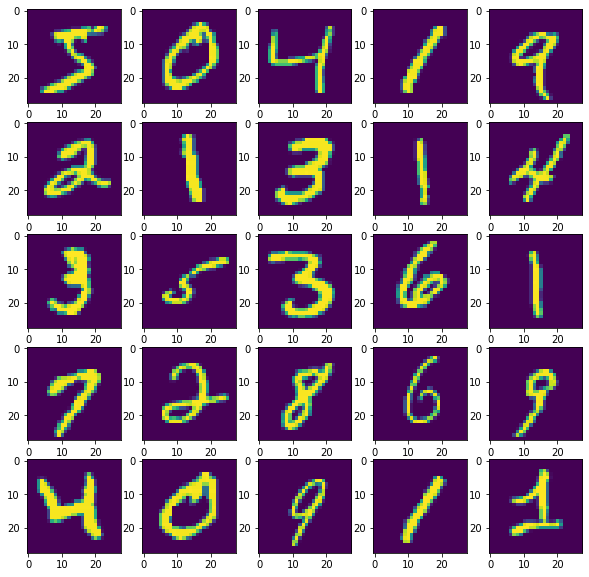

In [5]:
from matplotlib import pyplot
plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(25):
    plt.subplot(5,5,i+1)    
    plt.imshow(x_train[i])

plt.show()

**Reshaping the training data:**

In [32]:
X_train = x_train / 255.0
test = x_test / 255.0

In [33]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train[0:10000].reshape(-1,28,28,1)
test = test[0:10000].reshape(-1,28,28,1)

**Normalizing the image pixel valuess and One hot Encoding the output labels:**

In [37]:
Y_train = np_utils.to_categorical(y_train[0:10000], num_classes = 10)

In [38]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)

**Image data Augmentation:**

In [22]:
# With data augmentation to prevent overfitting 
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

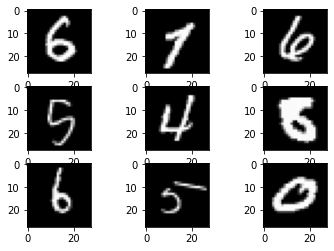

In [44]:
# Reshape image vectors
import numpy as np
datagen.fit(X_train)


for X_batch, y_batch in datagen.flow(X_train,Y_train, batch_size=9):
	# create a grid of 3x3 images augmented
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
	# show the plot
	plt.show()
	break

# Training the neural network

## **Dropout:**

In [45]:
from numpy import random as np_random
class dropout:
  def __init__(self, rate):
    self.rate = rate
    
  def __call__(self, inputs):
    keep_probability = 1 - rate
    mask = np_random.uniform(0, 1.0, inputs.shape) < keep_probability
   
    if keep_probability > 0.0:
        scale = (1/keep_probability)
    else:
        scale = 0.0
    return mask * inputs * scale

## **Relu Activation Layer:**

In [46]:
def relu(x):
  return np.maximum(0,x)

def relu2deriv(output):
  return output >= 0

## **Loss Function:**

In [47]:
class MSE:
  def __call__(self, y_true, y_pred):
    self.y_pred = y_pred
    self.y_true = y_true
    return((y_true - y_pred) ** 2).mean()
    
  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2.0 * (self.y_pred - self.y_true) / n
    return self.gradient

## **Linear Model:**

In [48]:
class Relu:
  def __call__(self, input_):
    self.input_ = input_
    self.output = np.clip(self.input_, 0, None)
    return self.output
  
  def backward(self, output_gradient):
    self.input_gradient = (self.input_ > 0) * output_gradient
    return self.input_gradient

In [49]:
class Linear:
  def __init__(self, in_dims: int, hidden: int = 1):
    self.weights = np.random.randn(in_dims, hidden) * np.sqrt(2. / in_dims)
    self.bias = np.zeros((hidden))
  
  def __call__(self,x):
    self.x = x
    output = x @ self.weights + self.bias
    return output
  
  def backward(self, gradient):
    self.weights_gradient = self.x.T @ gradient
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = gradient @ self.weights.T
    return self.x_gradient
  
  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

## **Defining the model:**

## **Hyperparameters:**

In [50]:
learning_rate, iterations, hidden_size = (0.016, 300, 100)
pixels_per_image, num_labels = (784, 10)
batch_size = 256
epochs = 401

In [51]:
from typing import Callable

class Model:

  # Configure model
  def __init__(self, input_dim, num_hidden):
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu1 = Relu()
    self.dropout1 = dropout(0.50)
    self.linear2 = Linear(num_hidden,500) 
    self.relu2 = Relu()
    self.dropout2 = dropout(0.50)
    self.linear3 = Linear(500,80)
    self.relu3 = Relu()
    self.dropout3 = dropout(0.50)
    self.linear4 = Linear(80,10)
  
  # Forward pass
  def __call__(self, x, training = None):
    l1 = self.linear1(x)
    r1 = self.relu1(l1)
    if training:
      r1 = self.dropout1(r1) # Add dropout
    l2 = self.linear2(r1)
    r2 = self.relu2(l2)
    if training:
      r2 = self.dropout2(r2) # Add dropout
    l3 = self.linear3(r2)
    r3 = self.relu3(l3)
    if training:
      r3 = self.dropout3(r3) # Add dropout
    l4 = self.linear4(r3)
    return l4
  
  # Backward pass
  def backward(self, output_gradient):
    linear4_gradient = self.linear4.backward(output_gradient)
    relu3_gradient = self.relu3.backward(linear4_gradient)
    linear3_gradient = self.linear3.backward(relu3_gradient)
    linear3_gradient = self.dropout3(linear3_gradient) # Add dropout
    relu2_gradient = self.relu2.backward(linear3_gradient)
    linear2_gradient = self.linear2.backward(relu2_gradient)
    linear2_gradient = self.dropout2(linear2_gradient) # Add dropout
    relu1_gradient = self.relu1.backward(linear2_gradient)
    linear1_gradient = self.linear1.backward(relu1_gradient)
    linear1_gradient = self.dropout1(linear1_gradient) # Add dropout
    return linear1_gradient

  # Update learnable parameters
  def update(self, lr):
    self.linear4.update(lr)
    self.linear3.update(lr)
    self.linear2.update(lr)
    self.linear1.update(lr)

## **Training and Fitting Model:**

In [62]:
test_images = x_test.reshape(len(x_test),28*28) / 255

In [64]:
y_test = np_utils.to_categorical(y_test[0:10000], num_classes = 10)

In [104]:
#Referenced from:
#https://github.com/iamtrask/Grokking-Deep-Learning/blob/master/Chapter8%20-%20Intro%20to%20Regularization%20-%20Learning%20Signal%20and%20Ignoring%20Noise.ipynb
#https://github.com/surabhigovil/Assignment3/blob/c5441d42c68b2677af9327833929ca2db161fb90/Part(A)/CMPE258_HW3_Part(a).ipynb

import numpy as np, sys

np.random.seed(1)

def fit(x: np.ndarray, y: np.ndarray, x_test: np.ndarray, y_test: np.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int, batch_size=1):
  Train_Acc, Test_Acc = [], []
  for j in range(iterations):
    # Training by batches
    correct_cnt = 0
    train_loss = 0.0
    
    for i in range(int(len(x)/batch_size)):
      batch_start, batch_end = ((i * batch_size),((i+1)*batch_size))
      y_pred = model(x[batch_start:batch_end], training=False)
      loss_value = loss(y_pred, y[batch_start:batch_end])
      gradient_from_loss = loss.backward()
      model = model.backward(gradient_from_loss)
      model = model.update(lr)
      
      for k in range(batch_size):
        correct_cnt += int(np.argmax(model[k:k+1]) == np.argmax(y[batch_start+k:batch_start+k+1]))

    test_correct_cnt = 0
    
    for i in range(len(x_test)):
      # Train Datset
      test_correct_cnt += int(np.argmax(model) == np.argmax(y_test[i:i+1]))

      if(j % 10 == 0):
        test_acc = test_correct_cnt/float(len(x_test))
        train_acc = correct_cnt/float(len(x))
        print(f'Test_Acc: {test_acc}, Train_Acc:{train_acc}')
        Train_Acc.append(train_acc)
        Test_Acc.append(test_acc)
  return Train_Loss, Train_Acc, Test_Loss, Test_Acc
  
# Define Learning Rate, Loss
loss = MSE() 
model = Model(784, 784) # Input dimension, Hidden dimension
Train_Acc, Test_Acc = fit(X_batch, y_batch, test_images, y_test, model=model, loss=loss, lr=learning_rate, num_epochs=epochs, batch_size=batch_size)

Streaming output truncated to the last 5000 lines.
Test_Acc: 0.4541, Train_Acc:0.0
Test_Acc: 0.4542, Train_Acc:0.0
Test_Acc: 0.4543, Train_Acc:0.0
Test_Acc: 0.4544, Train_Acc:0.0
Test_Acc: 0.4545, Train_Acc:0.0
Test_Acc: 0.4546, Train_Acc:0.0
Test_Acc: 0.4546, Train_Acc:0.0
Test_Acc: 0.4547, Train_Acc:0.0
Test_Acc: 0.4547, Train_Acc:0.0
Test_Acc: 0.4548, Train_Acc:0.0
Test_Acc: 0.4549, Train_Acc:0.0
Test_Acc: 0.455, Train_Acc:0.0
Test_Acc: 0.4551, Train_Acc:0.0
Test_Acc: 0.4552, Train_Acc:0.0
Test_Acc: 0.4553, Train_Acc:0.0
Test_Acc: 0.4554, Train_Acc:0.0
Test_Acc: 0.4555, Train_Acc:0.0
Test_Acc: 0.4556, Train_Acc:0.0
Test_Acc: 0.4557, Train_Acc:0.0
Test_Acc: 0.4558, Train_Acc:0.0
Test_Acc: 0.4559, Train_Acc:0.0
Test_Acc: 0.456, Train_Acc:0.0
Test_Acc: 0.4561, Train_Acc:0.0
Test_Acc: 0.4562, Train_Acc:0.0
Test_Acc: 0.4563, Train_Acc:0.0
Test_Acc: 0.4564, Train_Acc:0.0
Test_Acc: 0.4565, Train_Acc:0.0
Test_Acc: 0.4566, Train_Acc:0.0
Test_Acc: 0.4567, Train_Acc:0.0
Test_Acc: 0.4568, Train

## **Evaluation:**

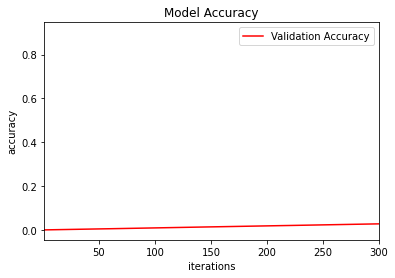

In [89]:
fig = plt.figure()
plt.plot(Test_Acc, color='r', label='Validation Accuracy')
plt.legend(loc=0)
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.xlim([1,iterations])

plt.title("Model Accuracy")
plt.show()